In [1]:
!pip install numpy matplotlib deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [3]:
class Murray_FDM:

    a: np.ndarray
    b: np.ndarray

    def __init__(self, l, d, p, dx, dt, size):

        dl = d / (p * l**2)
        lb = (dl * dt) / dx**2
        gamma1 = 1. - 0.5 * dt + lb
        gamma2 = 1. + 0.5 * dt - lb

        a = np.zeros((size, size))
        b = np.zeros((size, size))

        a[0,0], b[0,0] = 3 / (2 * dx), -3 / (2 * dx)
        a[0,1], b[0,1] = -4 / (2 * dx), 4 / (2 * dx)
        a[0,2], b[0,2] = 1 / (2 * dx), -1 / (2 * dx)

        a[-1, -1], b[-1, -1] = -3 / (2 * dx), 3 / (2 * dx)
        a[-1, -2], b[-1, -2] = 4 / (2 * dx), -4 / (2 * dx)
        a[-1, -3], b[-1, -3] = -1 / (2 * dx), 1 / (2 * dx)

        for i in range(1, size-1):
            a[i, i], b[i,i] = gamma1, gamma2
            a[i, i+1], b[i,i+1] = -0.5 * lb, 0.5 * lb
            a[i, i-1], b[i,i-1] = -0.5 * lb, 0.5 * lb

        self.a = a
        self.b = b

    def __call__(self, x):

        dir = self.b @ x
        return np.linalg.solve(self.a, dir)

    def solve(self, ic, it = 80):

        result = np.zeros((it, len(ic)))
        result[0] = ic

        for i in range(1, it): result[i] = self.__call__(result[i-1])

        return result

In [4]:
from os import times_result
# PARÂMETROS DIMENSIONAIS
l = 20
tf = 80

#PARAMETROS DO MODELO
d = 0.0139
p = 0.0553

# DISCRETIZAÇÃO DO ESPAÇO E TEMPO
space = np.linspace(0, 1, 1000)
time = np.linspace(0, tf * p, tf)

# INICIALIZAÇÃO DA CLASSE
murray = Murray_FDM(20, d, p, space[1], time[1], len(space))

In [41]:
def random_fn(quantidade, length_scale = 0.3, num = 1_000):

    space = dde.data.GRF(length_scale= length_scale)
    feats = space.random(quantidade)
    xs = np.linspace(0, 1, num=num, dtype = np.float32)[:, None]
    return space.eval_batch(feats, xs)

quantidade = 150
x = np.linspace(0, 1, 1000)
branch = random_fn(quantidade)

target =  np.zeros((quantidade, len(x) * tf), dtype = np.float32)
for i in range(quantidade): target[i] = murray.solve(branch[i]).flatten()
print('------ CRIAÇÃO TARGET CONCLUIDA -------')

t = np.arange(tf)
trunk = np.zeros((tf * len(x), 2), dtype = np.float32)
for i in range(len(t)):
    for j in range(len(x)):
        trunk[i * len(x) + j] = [t[i], x[j]]
print('------ CRIAÇÃO BRANCH CONCLUIDA -------')

print(f'Shapes: {branch.shape, trunk.shape, target.shape}')

------ CRIAÇÃO TARGET CONCLUIDA -------
------ CRIAÇÃO BRANCH CONCLUIDA -------
Shapes: ((150, 1000), (80000, 2), (150, 80000))


In [ ]:
division = 100
x_train, x_test = (branch[:i], trunk), (branch[i:], trunk)
y_train, y_test = target[:i], target[i:]

data = dde.data.TripleCartesianProd(
    X_train=x_train,
    y_train=y_train,
    X_test=x_test,
    y_test=y_test
)

net = dde.nn.DeepONetCartesianProd(
    [1000, 50, 50, 50],
    [2, 50, 50, 50],
    "relu",
    "Glorot normal",
)

model = dde.Model(data, net)
model.compile("adam", lr= 1e-3, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=50_000)

Compiling model...
Building DeepONetCartesianProd...
'build' took 0.083338 s

'compile' took 0.424880 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.58e+02]    [9.23e+02]    [1.11e+00]    
1000      [2.14e+01]    [2.23e+01]    [2.24e-01]    
2000      [1.54e+01]    [1.54e+01]    [1.84e-01]    
3000      [1.15e+01]    [1.21e+01]    [1.66e-01]    
4000      [4.95e+00]    [6.92e+00]    [1.27e-01]    
5000      [4.76e+00]    [6.49e+00]    [1.21e-01]    
6000      [6.12e+00]    [7.66e+00]    [1.27e-01]    
7000      [3.71e+00]    [5.17e+00]    [1.08e-01]    
8000      [2.84e+00]    [3.80e+00]    [9.34e-02]    
9000      [3.21e+00]    [3.94e+00]    [9.44e-02]    
10000     [2.35e+00]    [3.30e+00]    [8.77e-02]    
11000     [2.36e+00]    [3.25e+00]    [8.70e-02]    
12000     [4.91e+00]    [5.08e+00]    [1.03e-01]    
13000     [3.08e+00]    [4.14e+00]    [9.40e-02]    
14000     [1.87e+00]    [2.99e+00]    [8.22e-02]    
15000     [1.57e+00]    [2.5

In [43]:
input_fn = np.array(
    [np.exp(-100 * x**2)]
)
input = (input_fn, trunk)
output = model.predict(input)

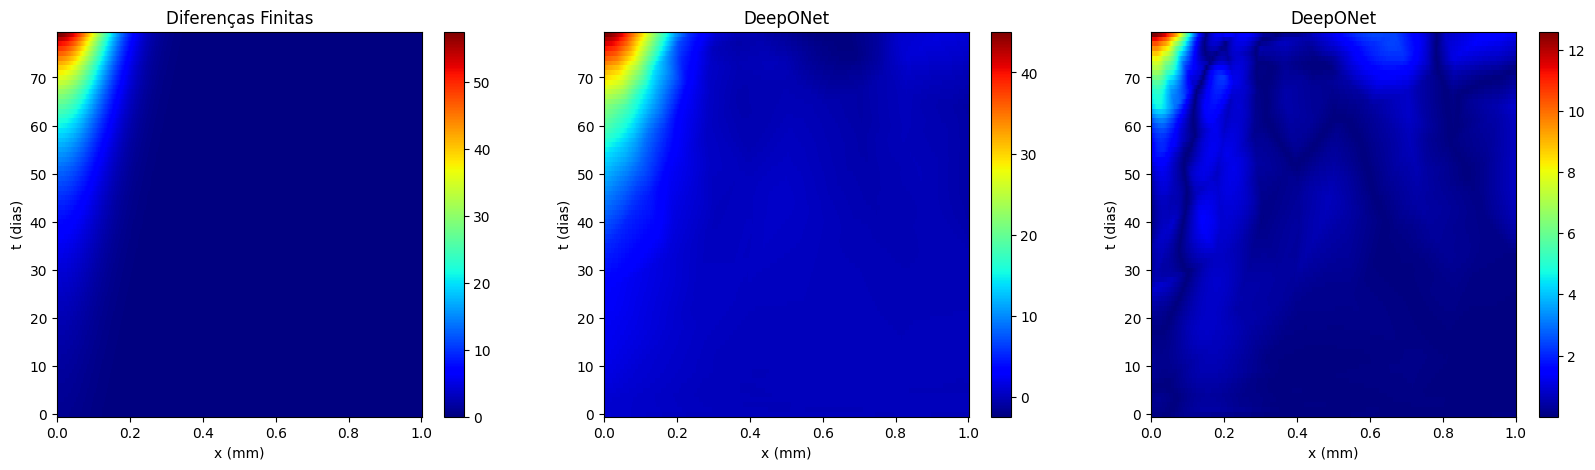

In [44]:
output = output.reshape(tf, len(x))
fdm_result = murray.solve(input_fn[0])

fig, ax = plt.subplots(ncols=3, figsize = (20, 5))

p1 = ax[0].pcolormesh(x, t, fdm_result, cmap = 'jet')
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('t (dias)')
ax[0].set_title('Diferenças Finitas')

p2 = ax[1].pcolormesh(x, t, output, cmap = 'jet')
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('t (dias)')
ax[1].set_title('DeepONet')

p3 = ax[2].pcolormesh(x, t, abs(output - fdm_result), cmap = 'jet')
ax[2].set_xlabel('x (mm)')
ax[2].set_ylabel('t (dias)')
ax[2].set_title('DeepONet')


plt.colorbar(p1)
plt.colorbar(p2)
plt.colorbar(p3)
plt.show()

In [48]:
def erro_total(pred, ref):

    return (1. - np.linalg.norm(pred - ref) / np.linalg.norm(ref)) * 100

erro_total(output, fdm_result)

82.43414451414455